# Feature Engineering: Building the Limit Order Book

In this notebook, I take a raw set of sequential limit orders, and update a bid or ask order book according to the newest event in the book.

The steps are:
* Read in the data and add empty columns for new features.
* Create a class OrderBook which will hold updated information for the order books.
* Create methods for OrderBook which will modify an order book. These methods contain the logic for how to modify an order book for a given event.
* Instantiate OrderBook objects for the bids and asks.
* Run through the data to update the order book objects, and fill in the new features for each row, given the state of the order books at that time.
* View ask/bid depths after processing.
* Save the updated data as a csv to be used for more processing in the next notebook.

In [33]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

soxx_1_06 = '../SOXX_book_events_sip-nasdaq_2017-01-06.csv'
#soxx_1_09 = "SOXX_book_events_sip-nasdaq_2017-01-09.csv"

data = pd.read_csv(soxx_1_06, index_col=[0])
data = data[data.side != 'U'] # 'U' as a side is given an error and is to be removed

print(data.shape) # 188k rows, 7 columns

(188076, 7)


In [34]:
data.head()

,timestamp,order_id,book_event_type,price,quantity,side,aux_quantity
0,1483706745349555268,2187624,A,10000000,100,B,0
1,1483706745349557645,2187628,A,199999990000000,100,A,0
2,1483707601849177770,2429788,A,124300000000,700,A,0
3,1483707602641135886,2429788,C,124300000000,0,A,700
4,1483707602641681537,2432900,A,124090000000,700,A,0


In [35]:
# check for na values - there are none
data.isna().sum()

timestamp          0
order_id           0
book_event_type    0
price              0
quantity           0
side               0
aux_quantity       0
dtype: int64

In [36]:
# check distribution of events
# majority of events are adds, modifies, or cancels - only 493 trades actually occur during the day.
data.book_event_type.value_counts()

A    62725
M    62500
C    62358
T      493
Name: book_event_type, dtype: int64

In [37]:
# transform price and timestamp into cleaner numbers
data['timestamp'] = data['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x/1000000000).strftime('%D %H:%M:%S.%f'))
data['price'] = data['price']/1000000000

In [38]:
# Create columns for features we will build from order book
data['best_bid'] = np.nan
data['best_ask'] = np.nan
data['mid_price'] = np.nan
data['bid_depth_10'] = np.nan
data['ask_depth_10'] = np.nan

bid_columns = []
ask_columns = []

for i in range(10, 0, -1):
    data['bid' + str(i)] = np.nan
    bid_columns.append('bid' + str(i))

for i in range(1,11):
    data['ask' + str(i)] = np.nan
    ask_columns.append('ask' + str(i))

<a id='OrderBook'></a>
### OrderBook Class 
OrderBook objects will store synthesized limit order book data that can be used to make predictions for future price movements. Each row in the dataframe affects the limit order book in some way. The methods of the OrderBook class make the appropriate changes to the order book, in order to extract the data we are interested in.

Comments/details regarding the logic for each of the methods are here: [Link](https://github.com/bshpringer/neural-network-stock-prediction/blob/master/info/OrderBook_Methods.ipynb)

In [39]:
from collections import defaultdict

class OrderBook:
    def __init__(self):
        self.orders = defaultdict(lambda: defaultdict(float))
        self.order_prices = defaultdict(lambda: defaultdict(float))
        self.current_prices = [0]
        
    def change_book(self, row):
        event = row.book_event_type
        
        if event == 'A':
            self.add_order(row)
        elif event == 'M':
            self.modify_order(row)
        elif event == 'C':
            self.cancel_order(row)
        elif event == 'T':
            self.trade_order(row)
            
        self.update_current_prices(row.side)
        
    def add_order(self, row):
        order_id = row.order_id
        self.orders[row.price][order_id] += row.quantity
        self.order_prices[order_id] = row.price
    
    def modify_order(self, row):
        order_id = row.order_id
        old_price = self.order_prices[order_id]
        del self.orders[old_price][order_id]
        self.orders[row.price][order_id] += row.quantity
        self.order_prices[order_id] = row.price
        if len(self.orders[old_price]) == 0:
            self.orders.pop(old_price)
        elif all(value <= 0 for value in self.orders[old_price].values()):
            self.orders.pop(old_price)
        
    def cancel_order(self, row):
        order_id = row.order_id
        self.orders[row.price].pop(order_id, None)
        del self.order_prices[order_id]
        if len(self.orders[row.price]) == 0:
            self.orders.pop(row.price)
        elif all(value <= 0 for value in self.orders[row.price].values()):
            self.orders.pop(row.price)
    
    def trade_order(self, row):
        order_id = row.order_id
        old_price = self.order_prices[order_id]
        self.orders[old_price][order_id] = row.aux_quantity

        if all(value <= 0 for value in self.orders[old_price].values()):
            self.orders.pop(old_price)
    
    def update_current_prices(self, side):
        if side == 'A':
            self.current_prices = sorted(self.orders.keys())
        elif side == 'B':
            self.current_prices = sorted(self.orders.keys(), reverse = True)
    
    def top_10_price_depth(self):
        top_10_prices = self.current_prices[0:10]
        return [sum(self.orders[price].values())*price for price in top_10_prices if price !=0]

In [40]:
# Helper method so that I always have 10 values to add for bids and asks
def append_nones(length, prices):
    diff_len = length - len(prices)
    return prices + [None] * diff_len

### Iterate through data

* Instantiate ask_book and bid_book
* Apply change method for a given row
* Pull figures we care about:

    * Current best bid/ask at the time
    * Sum of the top 10 price depths (price * total shares requested)
    * Individual depths for the top 10 prices
    
* Update the dataframe with all the calculated figures

In [42]:
%%time

ask_book = OrderBook()
bid_book = OrderBook()

for index, row in data[0:11000].iterrows():
    side = row.side
    
    if side == 'A':
        ask_book.change_book(row)
        
    elif side == 'B':
        bid_book.change_book(row)
        
    best_ask = ask_book.current_prices[0]
    best_bid = bid_book.current_prices[0]
    
    current_bid_depth = sum(bid_book.top_10_price_depth())
    current_ask_depth = sum(ask_book.top_10_price_depth())
    
    # align the bids depths with the columns
    top_10_bid_depths = bid_book.top_10_price_depth()
    appended_bids = append_nones(10,top_10_bid_depths)[::-1]
    
    top_10_ask_depth = ask_book.top_10_price_depth()
    appended_asks = append_nones(10, top_10_ask_depth)
    
    individual_columns = ['best_bid','best_ask', 'bid_depth_10','ask_depth_10']
    individual_figures = [best_bid, best_ask, current_bid_depth, current_ask_depth]
    
    update_columns = individual_columns + bid_columns + ask_columns
    update_stats = individual_figures + appended_bids + appended_asks
    
    data.loc[row.name, update_columns] = update_stats

CPU times: user 5min 30s, sys: 4.43 s, total: 5min 35s
Wall time: 5min 48s


#### 20 rows of data after 10,000 events and processing:

In [32]:
data.mid_price = (data.best_bid + data.best_ask)/2
data[9990:10000]

,timestamp,order_id,book_event_type,price,quantity,side,aux_quantity,datetime,best_bid,best_ask,...,ask1,ask2,ask3,ask4,ask5,ask6,ask7,ask8,ask9,ask10
9999,1483713730524008832,22821008,C,122.09,0,B,100,01/06/17 09:42:10.524009,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10000,1483713730524250432,22864264,C,122.10,0,B,100,01/06/17 09:42:10.524251,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10001,1483713730524674013,22965848,A,122.19,100,A,0,01/06/17 09:42:10.524674,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10002,1483713730524830438,7760928,M,116.01,100,B,100,01/06/17 09:42:10.524830,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10003,1483713730525265865,22441984,C,122.08,0,B,200,01/06/17 09:42:10.525266,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10004,1483713730525930218,22820784,C,122.09,0,B,200,01/06/17 09:42:10.525930,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10005,1483713730536275140,22912676,C,122.09,0,B,300,01/06/17 09:42:10.536275,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10006,1483713730541295044,22861744,C,122.64,0,A,100,01/06/17 09:42:10.541295,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10007,1483713730541362516,22966136,A,122.25,100,A,0,01/06/17 09:42:10.541363,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10008,1483713730541404806,22966140,A,122.25,200,A,0,01/06/17 09:42:10.541405,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Examples of what the bid and ask OrderBooks look like after 10,000 events, for the top 10 prices

In [16]:
for key in sorted(bid_book.orders, reverse=True)[0:10]:
    print("%s: %s" % (key, bid_book.orders[key]))

122.09: defaultdict(<class 'float'>, {22820780: 200.0})
122.08: defaultdict(<class 'float'>, {22885852: 300.0})
122.07: defaultdict(<class 'float'>, {22864524: 300.0, 22340900: 200.0})
122.06: defaultdict(<class 'float'>, {22692912: 100.0, 22818520: 300.0, 22861408: 200.0})
122.05: defaultdict(<class 'float'>, {22786216: 300.0, 22199744: 200.0})
122.04: defaultdict(<class 'float'>, {22741100: 300.0, 22773136: 200.0})
122.03: defaultdict(<class 'float'>, {22692520: 200.0, 22259240: 200.0})
122.02: defaultdict(<class 'float'>, {22288896: 200.0})
121.97: defaultdict(<class 'float'>, {12193864: 100.0})
121.96: defaultdict(<class 'float'>, {12193904: 100.0})


In [17]:
for key in sorted(ask_book.orders)[0:10]:
    print("%s: %s" % (key, ask_book.orders[key]))

122.19: defaultdict(<class 'float'>, {22958760: 100.0, 22965808: 200.0, 22965848: 100.0})
122.2: defaultdict(<class 'float'>, {22743516: 200.0, 22919956: 100.0, 22942204: 300.0, 22952516: 100.0})
122.21: defaultdict(<class 'float'>, {22790916: 200.0, 22869572: 300.0, 22919748: 200.0})
122.22: defaultdict(<class 'float'>, {22820500: 200.0, 22919760: 300.0})
122.23: defaultdict(<class 'float'>, {22869580: 200.0})
122.24: defaultdict(<class 'float'>, {22915884: 200.0})
122.25: defaultdict(<class 'float'>, {22966136: 100.0, 22966140: 200.0})
122.28: defaultdict(<class 'float'>, {22790320: 200.0})
122.3: defaultdict(<class 'float'>, {22884868: 200.0, 22885036: 200.0})
122.31: defaultdict(<class 'float'>, {12193908: 100.0})


#### Plot the ask/bid depths after 10,000 events to get a visual sense of what is happening. 

Middle is the mid_price. In theory, there may be some downward pressure on the mid price as there is a greater amount of ask order depth near the mid point, whereas bid orders are more spread out and away from the mid price.

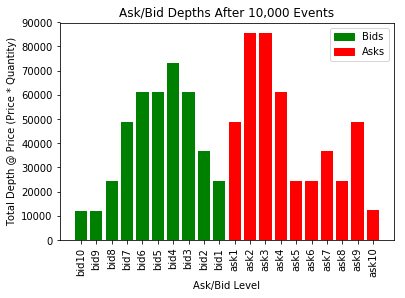

In [122]:
import matplotlib.patches as mpatches

current_depths = data.loc[10008][bid_columns + ask_columns]
depth_range = [x for x in range(-10,11) if x != 0]
plt.bar(bid_columns + ask_columns, current_bid_depths.values[0], color = ['g']*10 + ['r']*10)
plt.title('Ask/Bid Depths After 10,000 Events')
plt.xlabel('Ask/Bid Level')
plt.xticks(bid_columns + ask_columns, bid_columns + ask_columns, rotation='vertical')
asks = mpatches.Patch(color='r', label='Asks')
bids = mpatches.Patch(color='g', label='Bids')
plt.legend(handles=[bids,asks])
plt.ylabel('Total Depth @ Price (Price * Quantity)')
plt.show()

### Mid-Price Sanity Check

I want to see how the mid-price changed over the course of the day, and compare it to the trade prices over the course of the day, as well. In theory, they should be very close. Adds, modifies, cancels and trades can all affect the mid-price, but trade prices should somewhat reflect those changes, as well - even though there are only 500 trades throughout the day. If the two charts are similar, it gives me confidence that the logic for building the limit order books is working. 

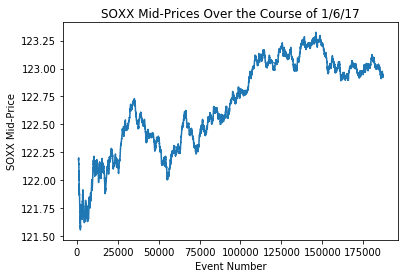

In [136]:
#new_data = pd.read_csv('SOXX_01_06_with_bids_depths.csv')
plt.plot(new_data.index[1000:-1000],new_data['mid_price'][1000:-1000])
plt.title('SOXX Mid-Prices Over the Course of 1/6/17')
plt.xlabel('Event Number')
plt.ylabel('SOXX Mid-Price')
plt.show()

Trades throughout the day

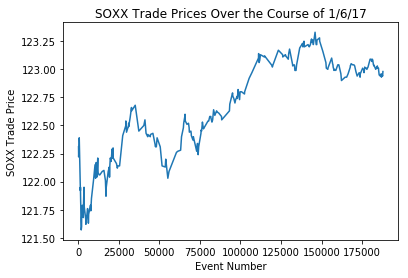

In [134]:
trades = data[data.book_event_type == "T"]
print("Total Trades")
plt.plot(trades.index, trades.price)
plt.title('SOXX Trade Prices Over the Course of 1/6/17')
plt.xlabel('Event Number')
plt.ylabel('SOXX Trade Price')
plt.show()

In [ ]:
# save data to a CSV so it can be processed further
# data.to_csv('SOXX_01_06_with_bids_depths.csv')
# data.to_csv('SOXX_01_09_with_bids_depths.csv')